In [205]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

In [16]:
def run_with_aer_sim(qc):
    aer_sim = Aer.get_backend("aer_simulator")
    qobj = assemble(transpile(qc, aer_sim))
    result = aer_sim.run(qobj).result()
    return result

## QROM

In [365]:
def qrom(database, name="db"):
    # Check if database is binary
    assert ((database == 0) | (database == 1)).all()
    
    def encode_row(i):
        row = database[i]
        for j in range(len(row)):
            if row[j] == 1:
                qc.mct(addr_qreg, data_qreg[j])

    def bit_diff_pos(a, b):
        return (addrs[i] ^ addrs[i-1]).bit_length() - 1

    def grey_code(n):
        return n ^ (n >> 1)
    
    nrows, ncols = database.shape
    addr_size = math.ceil(math.log2(nrows))
    addrs = [grey_code(n) for n in range(nrows)]
    
    addr_qreg = QuantumRegister(addr_size, name=f"{name}-address")
    data_qreg = QuantumRegister(ncols, name=f"{name}-data")
    
    qc = QuantumCircuit(addr_qreg, data_qreg)
    
    qc.x(addr_qreg)
    encode_row(0)
    
    qc.barrier()
    
    for i in range(1, len(addrs)):
        qc.x(addr_qreg[bit_diff_pos(addrs[i], addrs[i-1])])
        encode_row(addrs[i])
        qc.barrier()
    
    qc.name = name
    
    return qc

## Inner Product (out of place)

In [366]:
def inner_product(reg_sz, name="dot"):
    a = QuantumRegister(reg_sz, name=f"{name}_a")
    b = QuantumRegister(reg_sz, name=f"{name}_b")
    out = QuantumRegister(1, name=f"{name}_out")

    qc = QuantumCircuit(a, b, out)
    
    for i in range(reg_sz):
        qc.mct([a[i], b[i]], out)
        
    qc.name = name
    
    return qc

## Grover Search

In [43]:
from qiskit.algorithms import AmplificationProblem, Grover

In [79]:
good_state = ['11']

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

problem = AmplificationProblem(oracle, is_good_state = good_state)

problem.grover_operator.decompose().draw()

global phase: π
            ┌───┐┌───┐          ┌───┐┌───┐     
state_0: ─■─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
          │ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_1: ─■─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
            └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [85]:
sim = Aer.get_backend("aer_simulator")
grover = Grover(quantum_instance=sim)
result = grover.amplify(problem)
print(result.oracle_evaluation)
result.top_measurement

True


'11'

In [375]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

In [386]:
# A = np.array([[1, 1], [0, 1]])
# y = np.array([0, 1])
# z = np.array([1, 0])

# A = np.array([
#     [0, 1, 0, 0],
#     [1, 1, 1, 0],
#     [1, 0, 1, 1],
#     [1, 1, 1, 0]
# ])
# y = np.array([
#     0,
#     1,
#     1,
#     0
# ])
# z = np.array([
#     1,
#     0,
#     1,
#     1
# ])

A = np.array([
    [0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 1, 1],
    [0, 1, 1, 1, 0, 1, 0, 0]
])
y = np.array([1, 1, 1, 0, 1, 0, 1, 0])
z = np.array([1, 1, 1, 1, 1, 0, 1, 0])

num_solutions = 3

In [387]:
db = np.concatenate((A, z.reshape((1, -1)).T), axis=1)
nrows, ncols = A.shape
addr_size = math.ceil(math.log2(nrows))

addr_qreg = QuantumRegister(addr_size, name="address")
A_qreg = QuantumRegister(ncols, name="a")
y_qreg = QuantumRegister(nrows, name="y")
z_qreg = QuantumRegister(1, name="z")

data_out = ClassicalRegister(addr_size, name="data")

qc = QuantumCircuit(addr_qreg, A_qreg, y_qreg, z_qreg, data_out)

def encode_vector(qc, qreg, vec):
    a = vec.reshape(-1)
    
    for i in range(len(a)):
        if a[i] == 1:
            qc.x(qreg[i])

qc.h(addr_qreg)
encode_vector(qc, y_qreg, y)
qc.barrier()

qdb = qrom(db)
dot = inner_product(ncols)

# s1 = Statevector.from_instruction(qc).to_dict()

if num_solutions == 0:
    num_iterations = 1
else:
    num_iterations = Grover.optimal_num_iterations(num_solutions, addr_size)

for i in range(1):
    qc.append(qdb, [*addr_qreg, *A_qreg, *z_qreg])
    qc.append(dot, [*A_qreg, *y_qreg, *z_qreg])

    qc.z(z_qreg)

    qc.append(dot.inverse(), [*A_qreg, *y_qreg, *z_qreg])
    qc.append(qdb.inverse(), [*addr_qreg, *A_qreg, *z_qreg])
    qc.barrier()
    
    qc.append(diffuser(addr_size), [*addr_qreg])
qc.barrier()

# s2 = Statevector.from_instruction(qc).to_dict()

qc.measure([*addr_qreg], data_out)

# print(s1)
# print(s2)

qc.draw()

┌───┐ ░ ┌──────┐                          ┌─────────┐ ░ »
address_0: ┤ H ├─░─┤0     ├──────────────────────────┤0        ├─░─»
           ├───┤ ░ │      │                          │         │ ░ »
address_1: ┤ H ├─░─┤1     ├──────────────────────────┤1        ├─░─»
           ├───┤ ░ │      │                          │         │ ░ »
address_2: ┤ H ├─░─┤2     ├──────────────────────────┤2        ├─░─»
           └───┘ ░ │      │┌───────┐     ┌──────────┐│         │ ░ »
      a_0: ──────░─┤3     ├┤0      ├─────┤0         ├┤3        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_1: ──────░─┤4     ├┤1      ├─────┤1         ├┤4        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_2: ──────░─┤5     ├┤2      ├─────┤2         ├┤5        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_3: ──────░─┤6     ├┤3      ├─────┤3         ├┤6        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_4: ──────░─┤7     ├┤4      ├─────┤4         ├┤7        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_5: ──────░─┤8     ├┤5      ├─────┤5         ├┤8        ├─░─»
                 ░ │      ││       │     │          ││         │ ░ »
      a_6: ──────░─┤9     ├┤6      ├─────┤6         ├┤9        ├─░─»
                 ░ │   db ││       │     │          ││   db_dg │ ░ »
      a_7: ──────░─┤10    ├┤7      ├─────┤7         ├┤10       ├─░─»
           ┌───┐ ░ │      ││       │     │          ││         │ ░ »
      y_0: ┤ X ├─░─┤      ├┤8  dot ├─────┤8  dot_dg ├┤         ├─░─»
           ├───┤ ░ │      ││       │     │          ││         │ ░ »
      y_1: ┤ X ├─░─┤      ├┤9      ├─────┤9         ├┤         ├─░─»
           ├───┤ ░ │      ││       │     │          ││         │ ░ »
      y_2: ┤ X ├─░─┤      ├┤10     ├─────┤10        ├┤         ├─░─»
           └───┘ ░ │      ││       │     │          ││         │ ░ »
      y_3: ──────░─┤      ├┤11     ├─────┤11        ├┤         ├─░─»
           ┌───┐ ░ │      ││       │     │          ││         │ ░ »
      y_4: ┤ X ├─░─┤      ├┤12     ├─────┤12        ├┤         ├─░─»
           └───┘ ░ │      ││       │     │          ││         │ ░ »
      y_5: ──────░─┤      ├┤13     ├─────┤13        ├┤         ├─░─»
           ┌───┐ ░ │      ││       │     │          ││         │ ░ »
      y_6: ┤ X ├─░─┤      ├┤14     ├─────┤14        ├┤         ├─░─»
           └───┘ ░ │      ││       │     │          ││         │ ░ »
      y_7: ──────░─┤      ├┤15     ├─────┤15        ├┤         ├─░─»
                 ░ │      ││       │┌───┐│          ││         │ ░ »
        z: ──────░─┤11    ├┤16     ├┤ Z ├┤16        ├┤11       ├─░─»
                 ░ └──────┘└───────┘└───┘└──────────┘└─────────┘ ░ »
   data: 3/════════════════════════════════════════════════════════»
                                                                   »
«           ┌───────────┐ ░ ┌─┐      
«address_0: ┤0          ├─░─┤M├──────
«           │           │ ░ └╥┘┌─┐   
«address_1: ┤1 diffuser ├─░──╫─┤M├───
«           │           │ ░  ║ └╥┘┌─┐
«address_2: ┤2          ├─░──╫──╫─┤M├
«           └───────────┘ ░  ║  ║ └╥┘
«      a_0: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_1: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_2: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_3: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_4: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_5: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_6: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      a_7: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      y_0: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      y_1: ──────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«      y_2: ──────

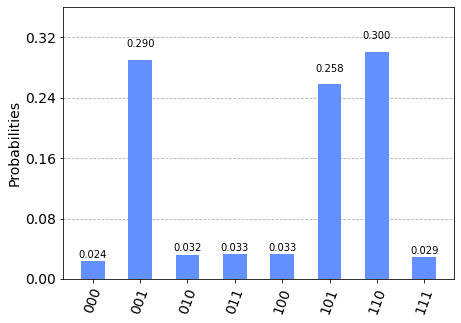

In [388]:
result = run_with_aer_sim(qc)
plot_histogram(result.get_counts())